# Stability analysis of the BOO gate

This notebook analyzes the stability of the BOO gate under relative Rabi pulse and absolute detuning errors. The code infrastructure used is the same as for the performance analysis for different sets of parameters. Scans of both the Rabi pulse and detuning error are performed independently and saved as .txt files to be compared to the eCD performance in the "comparison_stability.ipynb" notebook.

## Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qctrlvisualizer as qv
import boulderopal as bo

bo.cloud.set_verbosity("QUIET")
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    "$\\Omega$": opt["output"]["amplitude"],
    "$\\Delta$": opt["output"]["detuning"],
}

Boulder Opal client update available.
Latest version is 3.0.0, you have 2.1.3.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
# Set parameters.
Omega_0 = 17 * 2 * np.pi * 1e6  # rad/s
Delta_0 = 23 * 2 * np.pi * 1e6  # rad/s
duration0 = 540e-9 # s
cutoff_frequency = Omega_0
segment_count = 256

# Define system operators.
basis_labels = ["00", "01", "10", "11", "0r", "r0", "1r", "r1", "rr"]
drive_operator = np.zeros((9, 9))
drive_operator[([1, 2, 3, 3, 6, 7], [4, 5, 6, 7, 8, 8])] = 1

detuning_operator = np.diag([0, 0, 0, 0, 1, 1, 1, 1, 2])

blockade_operator = np.zeros((9, 9))
blockade_operator[8, 8] = 1

# Components for the CZ operator.
h_00 = np.zeros((9, 9))
h_00[0, 0] = 1
h_01 = np.zeros((9, 9))
h_01[1, 1] = 1
h_01[2, 2] = 1
h_11 = np.zeros((9, 9))
h_11[3, 3] = 1

### Optimizing the CZ gate

In [3]:
# Graph for blockade strengths B in rad/s.
def optimize_cz_gate(
    pulse_scheme, blockade_strength, duration, cost_node, optimization_count=10, **robustness
):
    graph = bo.Graph()
    tau = 0.175 * duration
    t0 = duration / 4
    a = np.exp(-((t0 / tau) ** 4))
    sample_times = np.linspace(0, duration, segment_count)

    if pulse_scheme == "ARP":
        # Create the discretized ARP envelope.
        times = np.linspace(0, duration / 2, segment_count)
        amplitude = (
            Omega_0
            * (np.exp(-(((times - t0) / tau) ** 4)) - np.exp(-((t0 / tau) ** 4)))
            / (1 - a)
        )
        detuning = Delta_0 * np.sin(2 * np.pi * (times - t0) / duration)

        Omega = graph.pwc_signal(values=amplitude, duration=duration / 2)
        Delta = graph.pwc_signal(values=detuning, duration=duration / 2)

        # 2 pulses to implement the gate.
        Omega = graph.time_concatenate_pwc([Omega, Omega], name="amplitude")
        Delta = graph.time_concatenate_pwc([Delta, Delta], name="detuning")

    else:
        opt_var_count = 20
        flat_gaussian_envelope = graph.signals.gaussian_pulse_pwc(
            duration=duration,
            segment_count=segment_count,
            amplitude=1,
            flat_duration=duration * 0.9,  # s
        )
        amplitude = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count, maximum=Omega_0, duration=duration
        )
        detuning = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count,
            maximum=Delta_0,
            minimum=-Delta_0,
            duration=duration,
        )
        Omega = graph.filter_and_resample_pwc(
            amplitude,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Omega = Omega * flat_gaussian_envelope
        Omega.name = "amplitude"
        Delta = graph.filter_and_resample_pwc(
            detuning,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Delta = Delta * flat_gaussian_envelope
        Delta.name = "detuning"

    # Create Hamiltonian.
    drive_term = graph.hermitian_part(Omega * drive_operator)
    delta_term = Delta * detuning_operator
    blockade_term = blockade_strength * blockade_operator
    hamiltonian = drive_term + delta_term + blockade_term

    # Single-qubit rotation is a free parameter, can be optimized for best fidelity.
    theta_s = graph.optimizable_scalar(
        lower_bound=0.0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
        name="theta_s",
    )

    # Define target operation.
    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)

    # Define noise list to include robustness.
    noise_list = []
    if robustness["dephasing"]:
        noise_list.append(detuning_operator / duration)
    if robustness["amplitude"]:
        noise_list.append(drive_term)
    penalty = robustness["decay"]

    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=target,
        noise_operators=noise_list,
        name="infidelity",
    )

    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times, name="unitary"
    )

    # Node to store blockade value used (in Hz).
    blockade = graph.abs(blockade_strength / 2 / np.pi)
    blockade.name = "blockade"

    # Node to store duration value used (in Hz).
    duration = graph.abs(duration)
    duration.name = "duration"

    decay_cost = graph.sum(
        graph.abs(unitary[:, 4, 1]) ** 2
        + graph.abs(unitary[:, 5, 2]) ** 2
        + graph.abs(unitary[:, 6, 3]) ** 2
        + graph.abs(unitary[:, 7, 3]) ** 2
        + 2 * graph.abs(unitary[:, 8, 3]) ** 2
    ) * (0.25 * sample_times[1] / sample_times[-1])

    decay_cost.name = "decay cost"

    cost = graph.log(infidelity + penalty * decay_cost, name="cost")

    result = bo.run_optimization(
        graph=graph,
        output_node_names=[
            "theta_s",
            "amplitude",
            "detuning",
            "unitary",
            "infidelity",
            "blockade",
            "duration",
            "decay cost",
        ],
        cost_node_name=cost_node,
        optimization_count=optimization_count,
    )

    return result

Gate infidelity is 4.944e-11
Single-qubit phase is 7.861


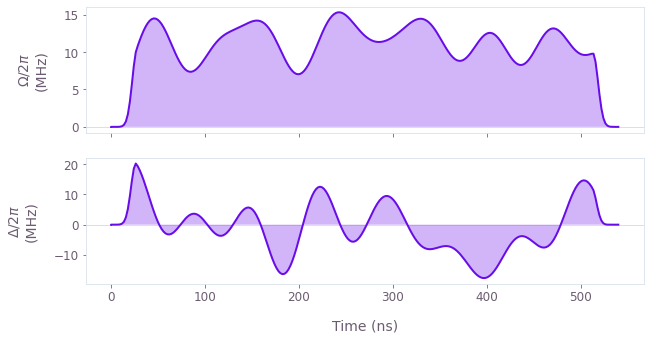

In [4]:
opt_result = optimize_cz_gate(
    pulse_scheme="opt",
    blockade_strength=2.5e9 * 2 * np.pi,
    duration = 1e-9 * 540,
    cost_node="infidelity",
    dephasing=False,
    amplitude=False,
    decay=0.0,
)

print("Gate infidelity is", f"{opt_result['output']['infidelity']['value']:.3e}")
print("Single-qubit phase is", f"{opt_result['output']['theta_s']['value']:.3f}")

qv.plot_controls(controls_for_plots(opt_result), smooth=True)

## Performing the error analysis

### Perform optimization for different Rydberg blockades and construct original Saffman gate

In [5]:
# Define the two analyzed blockade strengths.
blockades = 2 * np.pi * 1e6 * np.array([250, 2500])

# Original Saffman gate
blockade_scan_results = {}
with bo.cloud.group_requests():
    blockade_scan_results["ARP"] = [
        optimize_cz_gate(
            "ARP",
            blockade_strength=B,
            duration=duration0,
            cost_node="infidelity",
            dephasing=False,
            amplitude=False,
            decay=0.0,
        )
        for B in blockades
    ]

# BOO gate
with bo.cloud.group_requests():
    blockade_scan_results["Optimal, non-robust"] = [
        optimize_cz_gate(
            "optimal",
            blockade_strength=B,
            duration=duration0,
            cost_node="infidelity",
            dephasing=False,
            amplitude=False,
            decay=0.0,
        )
        for B in blockades
    ]

### Define a function to simulate the perfomance of BOO and Saffman gates under different errors

In [6]:
# Indices in the list of blockades for the chosen values.
B_indices = [0, 1]

# Defining the error ranges for the scan.
scan_point_count = 9
detuning_error_values = (np.linspace(-0.2, 0.2, num=scan_point_count) * 2 * np.pi * 1e6)  # rad/s
amplitude_error_values = np.linspace(-0.3, 0.3, num=scan_point_count)
center_value = int((scan_point_count-1)/2)

# Define control list.
control_list = [
    results[B_idx] for B_idx in B_indices for results in blockade_scan_results.values()
]

def run_coherent_simulation(
    scan_type, control_results, detuning_error_values, amplitude_error_values
):
    graph = bo.Graph()

    # Get blockade value
    B = control_results["output"]["blockade"]["value"] * 2 * np.pi

    # Get pulse values
    Omega = graph.pwc(**control_results["output"]["amplitude"])
    Delta = graph.pwc(**control_results["output"]["detuning"])

    #Make scan for amplitude
    if scan_type=='amplitude':
        detuning_error = graph.constant_pwc(
            constant=detuning_error_values[center_value, None, None],
            duration=duration0,
            batch_dimension_count=1,
        )
        amplitude_error = graph.constant_pwc(
            constant=amplitude_error_values[None, :, None],
            duration=duration0,
            batch_dimension_count=2,
        )
        
    # make scan for the detuning
    if scan_type=='detuning':
        detuning_error = graph.constant_pwc(
            constant=detuning_error_values[:, None, None],
            duration=duration0,
            batch_dimension_count=2,
        )
        amplitude_error = graph.constant_pwc(
            constant=amplitude_error_values[None, center_value, None],
            duration=duration0,
            batch_dimension_count=1,
        )

    # add noise to the hamiltonian
    hamiltonian = (
        graph.hermitian_part(Omega * (1.0 + amplitude_error) * drive_operator)
        + (Delta + detuning_error) * detuning_operator
        + B * blockade_operator
    )

    theta_s = control_results["output"]["theta_s"]["value"]

    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)

    infid = graph.infidelity_pwc(
        hamiltonian=hamiltonian, target=target, name="infidelity"
    )

    result = bo.execute_graph(graph, "infidelity")

    return result

### Simulate BOO and Saffman gates under different errors

In [7]:
# Run the amplitude error scans for ARP pulse.
with bo.cloud.group_requests():
    infidelity_scan_amplitude = [
        run_coherent_simulation('amplitude', control, detuning_error_values, amplitude_error_values)
        for control in control_list
    ]

# Extracting scan results.
error_scan_amplitude = {}
idx = 0
for B_idx in B_indices:
    scan_per_scheme_amplitude = {}
    for scheme in blockade_scan_results.keys():
        scan_per_scheme_amplitude[scheme] = infidelity_scan_amplitude[idx]["output"]["infidelity"]["value"]
        idx += 1
    error_scan_amplitude[B_idx] = scan_per_scheme_amplitude
    
# Run the dephasing error scans for ARP pulse.
with bo.cloud.group_requests():
    infidelity_scan_detuning = [
        run_coherent_simulation('detuning', control, detuning_error_values, amplitude_error_values)
        for control in control_list
    ]

# Extracting scan results.
error_scan_detuning = {}
idx = 0
for B_idx in B_indices:
    scan_per_scheme_detuning = {}
    for scheme in blockade_scan_results.keys():
        scan_per_scheme_detuning[scheme] = infidelity_scan_detuning[idx]["output"]["infidelity"]["value"]
        idx += 1
    error_scan_detuning[B_idx] = scan_per_scheme_detuning

### Store results in .txt files

In [8]:
# Save results of Rabi amplitude scan
np.savetxt('../data/omg_err_boo.txt', 
           [amplitude_error_values,
            error_scan_amplitude[0]["ARP"][0,:],
            error_scan_amplitude[0]["Optimal, non-robust"][0,:],
            error_scan_amplitude[1]["ARP"][0,:],
            error_scan_amplitude[1]["Optimal, non-robust"][0,:]
           ]) 

# Save result of detuning scan
np.savetxt('../data/delta_err_boo.txt',
           [detuning_error_values,
            error_scan_detuning[0]["ARP"][:,0],
            error_scan_detuning[0]["Optimal, non-robust"][:, 0],
            error_scan_detuning[1]["ARP"][:, 0],
            error_scan_detuning[1]["Optimal, non-robust"][:, 0]
            ])

### Plot the results

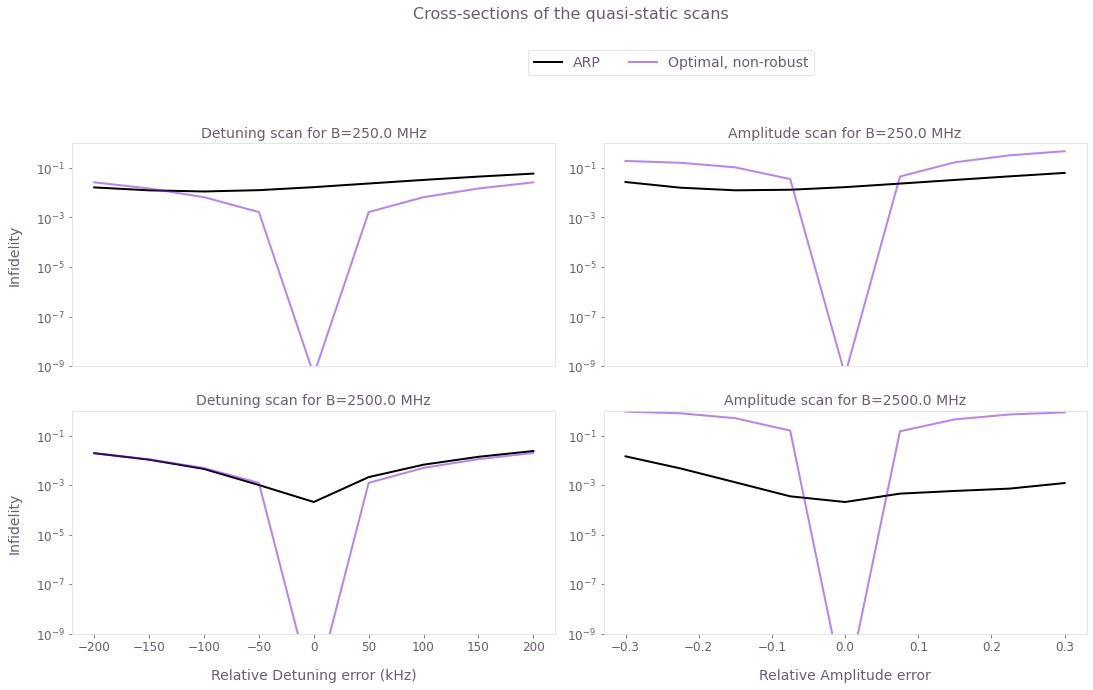

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))
fig.suptitle(f"Cross-sections of the quasi-static scans", y=1.15)
fig.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0.2)
for idx, B_idx in enumerate(B_indices):
    ax[idx][0].set_title(f"Detuning scan for B={blockades[B_idx]/2/np.pi/1e6} MHz")
    ax[idx][1].set_title(f"Amplitude scan for B={blockades[B_idx]/2/np.pi/1e6} MHz")
    ax[idx][0].plot(
        detuning_error_values / 2 / np.pi / 1e3,
        error_scan_detuning[B_idx]["ARP"][:, 0],
        label="ARP",
        c="k",
    )
    ax[idx][0].plot(
        detuning_error_values / 2 / np.pi / 1e3,
        error_scan_detuning[B_idx]["Optimal, non-robust"][:, 0],
        label="Optimal, non-robust",
        alpha=0.5,
    )
    ax[idx][1].plot(
        amplitude_error_values, 
        error_scan_amplitude[B_idx]["ARP"][0,:], 
        label="ARP", 
        c="k"
    )

    ax[idx][1].plot(
        amplitude_error_values,
        error_scan_amplitude[B_idx]["Optimal, non-robust"][0,:],
        label="Optimal, non-robust",
        alpha=0.5,
    )

    ax[idx][0].set_ylabel("Infidelity")
    ax[0][idx].set_xticks([])
for a in ax.ravel():
    a.set_yscale("log")
    a.set_ylim(1e-9, 1e-0)
ax[1][0].set_xlabel("Relative Detuning error (kHz)")
ax[1][1].set_xlabel("Relative Amplitude error")
ax[0][0].legend(loc="best", bbox_to_anchor=(1.55, 1.45), ncol=3)
plt.show()